**Van Hees Inactivity Detection**

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import matplotlib.pyplot as plt

# ============================================================
# VAN HEES ALGORITHM – BATCH PROCESSING FOR ALL SUBJECTS
# This script applies the Van Hees inactivity algorithm to
# accelerometer data from Embrace Plus and Empatica devices.
# ============================================================

# --------------------
# Van Hees parameters
# --------------------
INACTIVITY_WINDOW_MIN = 5        # Inactivity window in minutes
ANGLE_TOLERANCE_DEG = 1.0        # Angle change tolerance (degrees)
ESTIMATED_FS = 32                # Expected sampling frequency (Hz)

# --------------------
# Base paths
# --------------------
base_embrace = os.path.expanduser("~/TFM/2.step2_e4csv")
base_empatica = os.path.expanduser("~/TFM/EMPATICA_all")
base_output = os.path.expanduser("~/TFM/6.Van_Hees")
os.makedirs(base_output, exist_ok=True)

# ============================================================
# Helper functions
# ============================================================

def compute_angle(x, y, z):
    """
    Compute body angle in degrees according to Van Hees definition.
    """
    return np.degrees(np.arctan2(z, np.sqrt(x**2 + y**2)))


def load_empatica_acc(path, n_cols=3):
    """
    Load Empatica ACC file in E4 format.
    Returns timestamps (epoch seconds), sampling frequency, and ACC values.
    """
    data = pd.read_csv(path, header=None, na_values=["NA", "", "NaN"])
    start_time = float(data.iloc[0, 0])
    freq = float(data.iloc[1, 0])
    values = data.iloc[2:, :n_cols].astype(float).values
    timestamps = start_time + np.arange(len(values)) / freq
    return timestamps, freq, values


def load_embrace_acc(sensor_dir, n_cols=3):
    """
    Load and concatenate Embrace ACC parts (partXX.csv).
    """
    parts = sorted(
        [f for f in os.listdir(sensor_dir) if f.startswith("part") and f.endswith(".csv")]
    )
    if not parts:
        raise FileNotFoundError(f"No partXX.csv files found in {sensor_dir}")

    all_values = []
    all_timestamps = []

    for part in parts:
        path = os.path.join(sensor_dir, part)
        data = pd.read_csv(path, header=None, na_values=["NA", "", "NaN"])
        t0 = float(data.iloc[0, 0])
        freq = float(data.iloc[1, 0])
        vals = data.iloc[2:, :n_cols].astype(float).values
        ts = t0 + np.arange(len(vals)) / freq

        all_values.append(vals)
        all_timestamps.append(ts)

    return np.concatenate(all_timestamps), freq, np.vstack(all_values)


def apply_van_hees(timestamps, freq, acc_vals, subject_id, device_type, output_root):
    """
    Apply Van Hees inactivity detection and save a 1 Hz inactivity mask.
    """
    print(f"Processing {subject_id} ({device_type})")

    # Build DataFrame indexed by time
    df = pd.DataFrame(acc_vals, columns=["x", "y", "z"])
    df["timestamp"] = pd.to_datetime(timestamps, unit="s", utc=True)
    df = df.set_index("timestamp")

    # Compute body angle and median filter
    df["angle"] = compute_angle(df["x"], df["y"], df["z"])
    df["angle_med"] = medfilt(df["angle"], kernel_size=5)

    # Absolute angle change
    delta = df["angle_med"].diff().abs().fillna(0)

    # Inactivity window in samples
    window_samples = int(freq * 60 * INACTIVITY_WINDOW_MIN)

    # Inactivity detection: small angle changes over the window
    inactivity = (
        delta.rolling(window=window_samples, min_periods=1).max()
        < ANGLE_TOLERANCE_DEG
    )

    # Resample to 1 Hz inactivity mask
    mask_1hz = inactivity.resample("1s").max().fillna(0).astype(int)

    # Save output
    out_dir = os.path.join(output_root, device_type, subject_id)
    os.makedirs(out_dir, exist_ok=True)

    df_out = pd.DataFrame({
        "timestamp": mask_1hz.index.astype(np.int64) // 10**9,
        "sleep_mask": mask_1hz.values
    })

    out_path = os.path.join(out_dir, "ACC_sleep_masked.csv")
    df_out.to_csv(out_path, index=False)

    print(f"Saved: {out_path}")
    print(f"Inactive seconds detected: {int(mask_1hz.sum())}")

    return len(df_out), int(mask_1hz.sum())

# ============================================================
# Global processing (Embrace + Empatica)
# ============================================================

def process_all(subject_map):
    """
    Run Van Hees algorithm for all paired Embrace/Empatica subjects.
    """
    summary = []

    for embrace_id, empatica_id in subject_map.items():
        try:
            # Embrace processing
            embrace_acc_dir = os.path.join(base_embrace, embrace_id, "ACC_filtrado")
            ts_e, fs_e, acc_e = load_embrace_acc(embrace_acc_dir)
            total_e, inactive_e = apply_van_hees(
                ts_e, fs_e, acc_e,
                subject_id=embrace_id,
                device_type="Embrace_mask",
                output_root=base_output
            )

            # Empatica processing
            empatica_acc_path = os.path.join(base_empatica, empatica_id, "ACC.csv")
            ts_m, fs_m, acc_m = load_empatica_acc(empatica_acc_path)
            total_m, inactive_m = apply_van_hees(
                ts_m, fs_m, acc_m,
                subject_id=empatica_id,
                device_type="Empatica_mask",
                output_root=base_output
            )

            summary.append({
                "embrace_id": embrace_id,
                "empatica_id": empatica_id,
                "embrace_inactive_pct": round(100 * inactive_e / total_e, 2),
                "empatica_inactive_pct": round(100 * inactive_m / total_m, 2),
            })

        except Exception as e:
            print(f"Error processing {embrace_id}/{empatica_id}: {e}")

    df_summary = pd.DataFrame(summary)
    out_summary = os.path.join(base_output, "summary_vanhees.csv")
    df_summary.to_csv(out_summary, index=False)

    print("Global summary saved to:", out_summary)
    print(df_summary)

# ============================================================
# Main
# ============================================================

if __name__ == "__main__":
    emp_emp_map = {
        "CLIDEM01": "1823370",
        "CLIDEM010": "1842113",
        "CLIDEM011": "1891004",
        "CLIDEM02": "1832743",
        "CLIDEM030": "1916330",
        "CLIDEM031": "1920720",
        "CLIDEM04": "1833368",
        "CLIDEM05": "1837341",
        "CLIDEM06": "1840660",
        "CLIDEM07": "1840605",
        "CLIDEM08": "1841430",
        "CLIDEM09": "1842162",
        "CLIDEM11": "1891004",
        "CLIDEM12": "1891236",
        "CLIDEM13": "1895868",
        "CLIDEM14": "1891785",
        "CLIDEM15": "1894131",
        "CLIDEM16": "1895849",
        "CLIDEM17": "1896649",
        "CLIDEM18": "1898066",
        "CLIDEM19": "1900189",
        "CLIDEM20": "1906938",
        "CLIDEM21": "1907236",
        "CLIDEM22": "1908525",
        "CLIDEM23": "1909384",
        "CLIDEM24": "1910353",
        "CLIDEM25": "1911867",
        "CLIDEM26": "1912600",
        "CLIDEM27": "1913365",
        "CLIDEM29": "1914654"
    }

    process_all(emp_emp_map)


🔍 Procesando CLIDEM01 (Embrace_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Embrace_mask/CLIDEM01/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 28990 s

🔍 Procesando 1823370 (Empatica_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Empatica_mask/1823370/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 11685 s

🔍 Procesando CLIDEM010 (Embrace_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Embrace_mask/CLIDEM010/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 48550 s

🔍 Procesando 1842113 (Empatica_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Empatica_mask/1842113/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 27776 s

🔍 Procesando CLIDEM011 (Embrace_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Embrace_mask/CLIDEM011/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 33859 s

🔍 Procesando 1891004 (Empatica_mask)
✅ Guardado /home/yasmina/TFM/6.Van_Hees/Empatica_mask/1891004/ACC_sleep_masked.csv
   Tramos de inactividad detectados: 30855 s


**Comparative Visualization of EDA, Temperature and Acceleration with Van Hees Inactivity Mask**

/tmp/ipykernel_1261389/2778349506.py:158: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


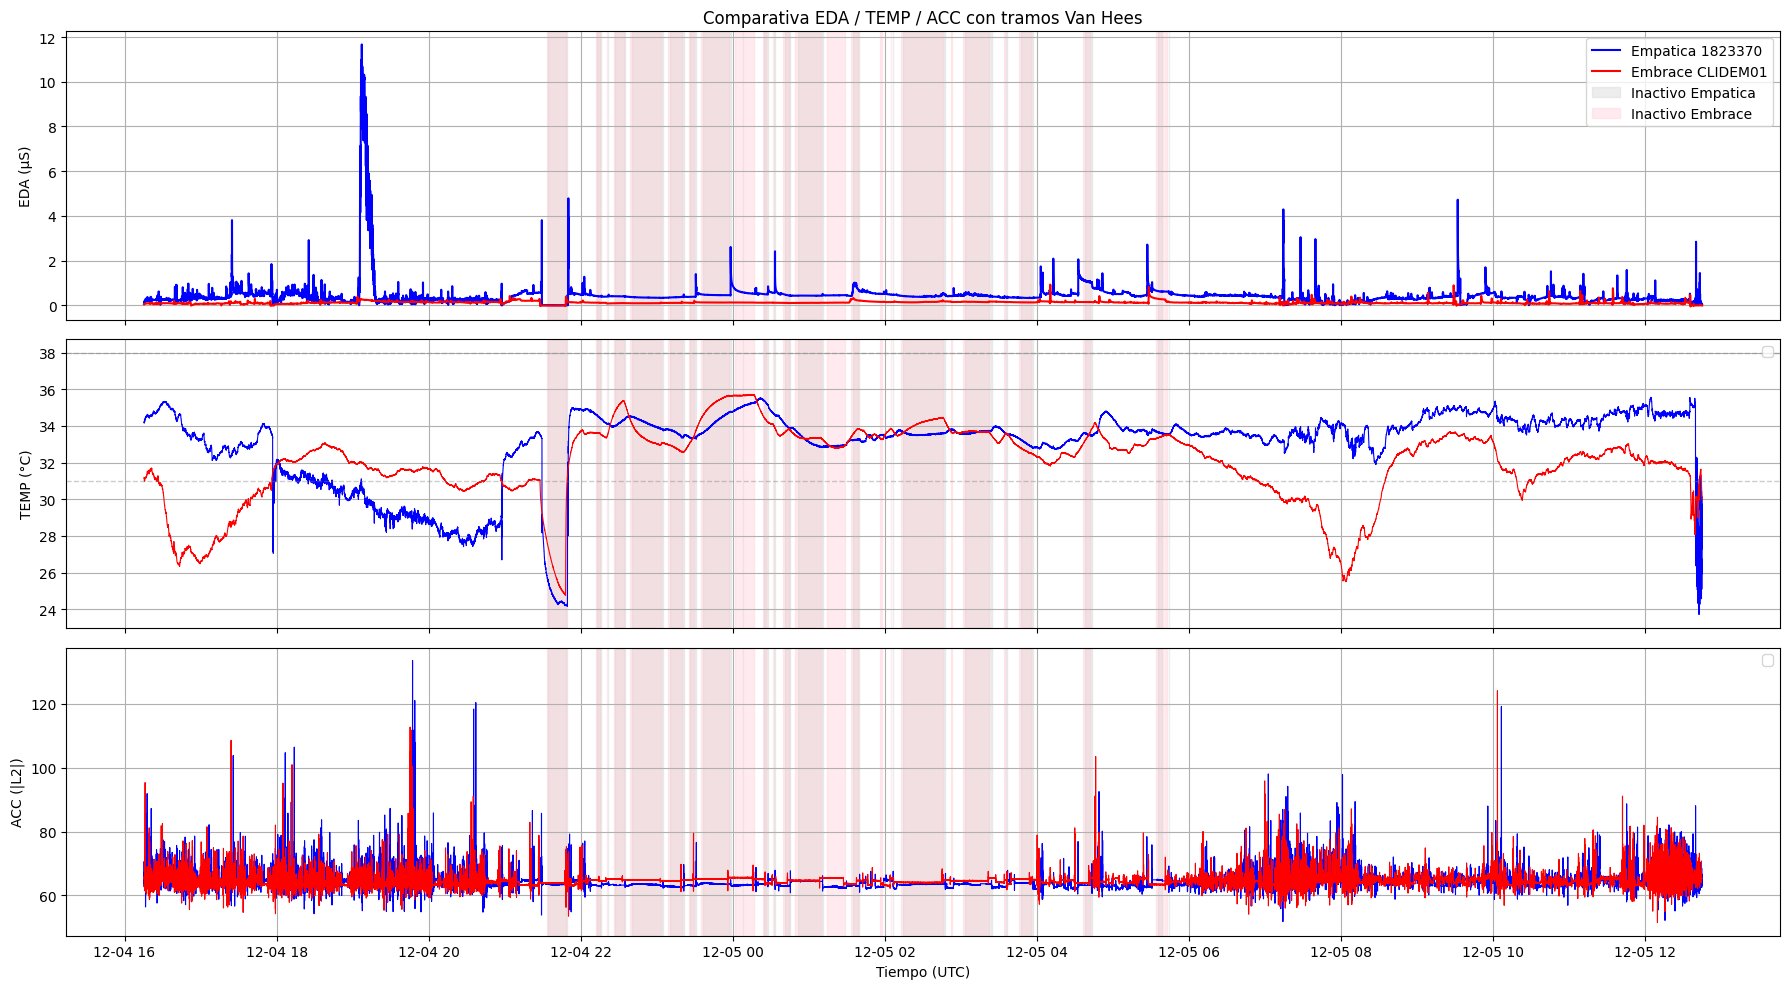

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# COMPARISON OF EDA, TEMP AND ACC WITH VAN HEES INACTIVITY MASKS
# Empatica vs Embrace
# ============================================================

# --------------------
# Helper functions
# --------------------

def read_eda_file(path):
    """
    Read an EDA file in Empatica/Embrace format and return a time series DataFrame.
    """
    d = pd.read_csv(path, header=None, na_values=["NA", "NaN", ""])
    t0 = float(d.iloc[0, 0])
    freq = float(d.iloc[1, 0])
    vals = pd.to_numeric(d.iloc[2:, 0], errors="coerce").dropna().values
    ts = t0 + np.arange(len(vals)) / freq
    return pd.DataFrame({
        "time": pd.to_datetime(ts, unit="s"),
        "value": vals
    })


def read_temp_file(path):
    """
    Read a TEMP file in Empatica/Embrace format and return a time series DataFrame.
    """
    d = pd.read_csv(path, header=None, na_values=["NA", "NaN", ""])
    t0 = float(d.iloc[0, 0])
    freq = float(d.iloc[1, 0])
    vals = pd.to_numeric(d.iloc[2:, 0], errors="coerce").dropna().values
    ts = t0 + np.arange(len(vals)) / freq
    return pd.DataFrame({
        "time": pd.to_datetime(ts, unit="s"),
        "value": vals
    })


def read_acc_file(path, n_cols=3):
    """
    Read an ACC file and return the vector magnitude |L2|.
    """
    d = pd.read_csv(path, header=None, na_values=["NA", "NaN", ""])
    t0 = float(d.iloc[0, 0])
    freq = float(d.iloc[1, 0])

    vals = (
        pd.to_numeric(d.iloc[2:, :n_cols].stack(), errors="coerce")
        .unstack()
        .dropna()
        .values
    )

    ts = t0 + np.arange(len(vals)) / freq
    mag = np.linalg.norm(vals, axis=1)

    return pd.DataFrame({
        "time": pd.to_datetime(ts, unit="s"),
        "value": mag
    })


def read_embrace_parts(sensor_dir, reader_func):
    """
    Read and concatenate all partXX.csv files for a given Embrace sensor.
    """
    parts = sorted([
        f for f in os.listdir(sensor_dir)
        if f.lower().startswith("part") and f.lower().endswith(".csv")
    ])
    if not parts:
        raise FileNotFoundError(f"No partXX.csv files found in {sensor_dir}")

    dfs = [reader_func(os.path.join(sensor_dir, p)) for p in parts]
    return pd.concat(dfs, ignore_index=True).sort_values("time")


def read_mask(path, col_name="sleep_mask"):
    """
    Read a Van Hees inactivity mask file.
    """
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["timestamp"], unit="s")
    df[col_name] = df[col_name].astype(int)
    return df


def get_intervals(df_mask, col="sleep_mask"):
    """
    Extract contiguous inactivity intervals where mask == 1.
    """
    df_mask["flag"] = (df_mask[col] == 1).astype(int)
    intervals = []
    start = None

    for i in range(1, len(df_mask)):
        prev = df_mask["flag"].iloc[i - 1]
        curr = df_mask["flag"].iloc[i]

        if curr == 1 and prev == 0:
            start = df_mask["time"].iloc[i]
        elif curr == 0 and prev == 1 and start is not None:
            end = df_mask["time"].iloc[i]
            intervals.append((start, end))
            start = None

    return intervals


def downsample(df):
    """
    Downsample a signal to 1 Hz by averaging per second.
    """
    df["sec"] = df["time"].dt.floor("1s")
    return (
        df.groupby("sec", as_index=False)["value"]
        .mean()
        .rename(columns={"sec": "time"})
    )

# ============================================================
# Main plotting function
# ============================================================

def plot_compare_all(empatica_id,
                     embrace_id,
                     base_empatica="~/TFM/EMPATICA_all",
                     base_embrace="~/TFM/2.step2_e4csv",
                     base_mask_empatica="~/TFM/6.Van Hees/Empatica_mask",
                     base_mask_embrace="~/TFM/6.Van Hees/Embrace_mask",
                     save_fig=False):
    """
    Plot EDA, TEMP and ACC signals for Empatica and Embrace,
    highlighting inactivity intervals detected by Van Hees.
    """

    # Expand base paths
    base_empatica = os.path.expanduser(base_empatica)
    base_embrace = os.path.expanduser(base_embrace)
    base_mask_empatica = os.path.expanduser(base_mask_empatica)
    base_mask_embrace = os.path.expanduser(base_mask_embrace)

    # File paths
    emp = {
        "EDA": os.path.join(base_empatica, empatica_id, "EDA.csv"),
        "TEMP": os.path.join(base_empatica, empatica_id, "TEMP.csv"),
        "ACC": os.path.join(base_empatica, empatica_id, "ACC.csv"),
        "MASK": os.path.join(base_mask_empatica, empatica_id, "ACC_sleep_masked.csv"),
    }
    emb = {
        "EDA": os.path.join(base_embrace, embrace_id, "EDA_filtrado"),
        "TEMP": os.path.join(base_embrace, embrace_id, "TEMP"),
        "ACC": os.path.join(base_embrace, embrace_id, "ACC_filtrado"),
        "MASK": os.path.join(base_mask_embrace, embrace_id, "ACC_sleep_masked.csv"),
    }

    # Read Empatica signals
    df_eda_emp = read_eda_file(emp["EDA"])
    df_temp_emp = read_temp_file(emp["TEMP"])
    df_acc_emp = read_acc_file(emp["ACC"])

    # Read Embrace signals (concatenated parts)
    df_eda_emb = read_embrace_parts(emb["EDA"], read_eda_file)
    df_temp_emb = read_embrace_parts(emb["TEMP"], read_temp_file)
    df_acc_emb = read_embrace_parts(emb["ACC"], read_acc_file)

    # Read inactivity masks
    mask_e = read_mask(emp["MASK"])
    mask_m = read_mask(emb["MASK"])

    # Determine common time window
    t_min = max(
        df_eda_emp["time"].min(),
        df_eda_emb["time"].min(),
        mask_e["time"].min(),
        mask_m["time"].min(),
    )
    t_max = min(
        df_eda_emp["time"].max(),
        df_eda_emb["time"].max(),
        mask_e["time"].max(),
        mask_m["time"].max(),
    )

    def crop(df):
        return df[(df["time"] >= t_min) & (df["time"] <= t_max)]

    df_eda_emp, df_temp_emp, df_acc_emp = map(crop, [df_eda_emp, df_temp_emp, df_acc_emp])
    df_eda_emb, df_temp_emb, df_acc_emb = map(crop, [df_eda_emb, df_temp_emb, df_acc_emb])
    mask_e, mask_m = map(crop, [mask_e, mask_m])

    # Downsample to 1 Hz
    df_eda_emp, df_temp_emp, df_acc_emp = map(downsample, [df_eda_emp, df_temp_emp, df_acc_emp])
    df_eda_emb, df_temp_emb, df_acc_emb = map(downsample, [df_eda_emb, df_temp_emb, df_acc_emb])

    # Inactivity intervals
    sleep_emp = get_intervals(mask_e, col="sleep_mask")
    sleep_emb = get_intervals(mask_m, col="sleep_mask")

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

    # EDA
    axs[0].plot(df_eda_emp["time"], df_eda_emp["value"], color="blue", label=f"Empatica {empatica_id}")
    axs[0].plot(df_eda_emb["time"], df_eda_emb["value"], color="red", label=f"Embrace {embrace_id}")
    axs[0].set_ylabel("EDA (µS)")
    axs[0].set_title("EDA, TEMP and ACC comparison with Van Hees inactivity periods")

    for (s, e) in sleep_emp:
        axs[0].axvspan(s, e, color="lightgray", alpha=0.4)
    for (s, e) in sleep_emb:
        axs[0].axvspan(s, e, color="pink", alpha=0.3)

    # TEMP
    axs[1].plot(df_temp_emp["time"], df_temp_emp["value"], color="blue", linewidth=0.8)
    axs[1].plot(df_temp_emb["time"], df_temp_emb["value"], color="red", linewidth=0.8)
    axs[1].set_ylabel("TEMP (°C)")
    axs[1].axhline(31, color="gray", linestyle="--", linewidth=1, alpha=0.4)
    axs[1].axhline(38, color="gray", linestyle="--", linewidth=1, alpha=0.4)

    for (s, e) in sleep_emp:
        axs[1].axvspan(s, e, color="lightgray", alpha=0.4)
    for (s, e) in sleep_emb:
        axs[1].axvspan(s, e, color="pink", alpha=0.3)

    # ACC
    axs[2].plot(df_acc_emp["time"], df_acc_emp["value"], color="blue", linewidth=0.8)
    axs[2].plot(df_acc_emb["time"], df_acc_emb["value"], color="red", linewidth=0.8)
    axs[2].set_ylabel("ACC (|L2|)")
    axs[2].set_xlabel("Time (UTC)")

    for (s, e) in sleep_emp:
        axs[2].axvspan(s, e, color="lightgray", alpha=0.4)
    for (s, e) in sleep_emb:
        axs[2].axvspan(s, e, color="pink", alpha=0.3)

    for ax in axs:
        ax.grid(True)
        ax.legend(loc="upper right")

    plt.tight_layout()

    if save_fig:
        out_path = os.path.expanduser(
            f"~/TFM/6.Van Hees/compare_ALL_{empatica_id}_{embrace_id}.png"
        )
        plt.savefig(out_path, dpi=150)
    else:
        plt.show()


# ============================================================
# Example execution
# ============================================================

if __name__ == "__main__":
    plot_compare_all(empatica_id="1823370", embrace_id="CLIDEM01")